# 布林通道

### Import model

In [266]:
import pandas as pd
import csv
import matplotlib.pyplot as plt
import yfinance as yf
from pandas_datareader import data as pdr
import numpy as np
import quantstats as qs
import seaborn as sns
import matplotlib.pyplot as py

### Import data

In [267]:
yf.pdr_override()
tickers = "0050.TW"
df = pdr.get_data_yahoo(tickers, start="2021-01-01", end="2023-10-31")
df.reset_index(inplace=True)
df['Date'] = df['Date'].dt.strftime('%Y/%m/%d')
df

[*********************100%***********************]  1 of 1 completed


,Date,Open,High,Low,Close,Adj Close,Volume
0,2021/01/04,122.199997,124.500000,122.000000,124.349998,114.271156,6140797
1,2021/01/05,124.199997,124.650002,123.750000,124.599998,114.500893,4731570
2,2021/01/06,126.099998,127.150002,124.099998,125.949997,115.741470,10587073
3,2021/01/07,126.550003,129.000000,126.550003,128.899994,118.452362,6691163
4,2021/01/08,130.600006,131.250000,129.550003,131.199997,120.565941,12990245
...,...,...,...,...,...,...,...
679,2023/10/24,123.800003,123.949997,122.699997,123.949997,123.949997,7197186
680,2023/10/25,124.199997,124.900002,124.199997,124.199997,124.199997,3980090
681,2023/10/26,121.849998,122.400002,121.599998,121.750000,121.750000,21974122
682,2023/10/27,122.150002,122.750000,122.099998,122.300003,122.300003,4068937


### Observe data

Text(0.5, 1.0, 'Close Price History')

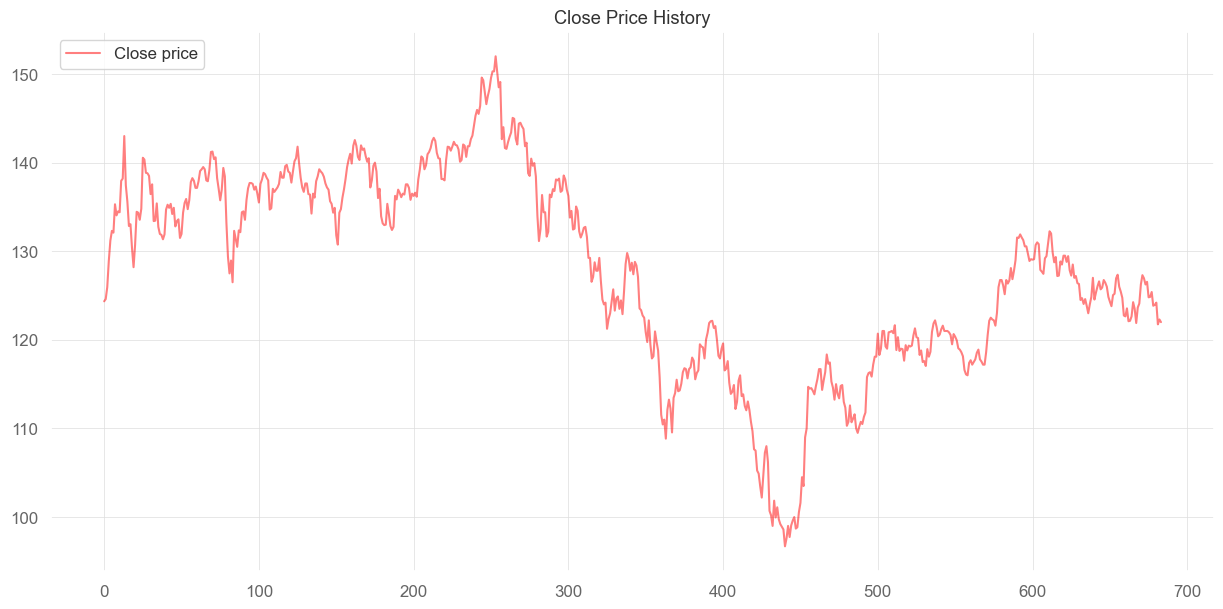

In [268]:
plt.figure(figsize = (15,7))
plt.plot(df['Close'],color='red',alpha=0.5, label = 'Close price')
plt.legend(loc='upper left')
plt.title('Close Price History')

Text(0.5, 1.0, 'Volumn History')

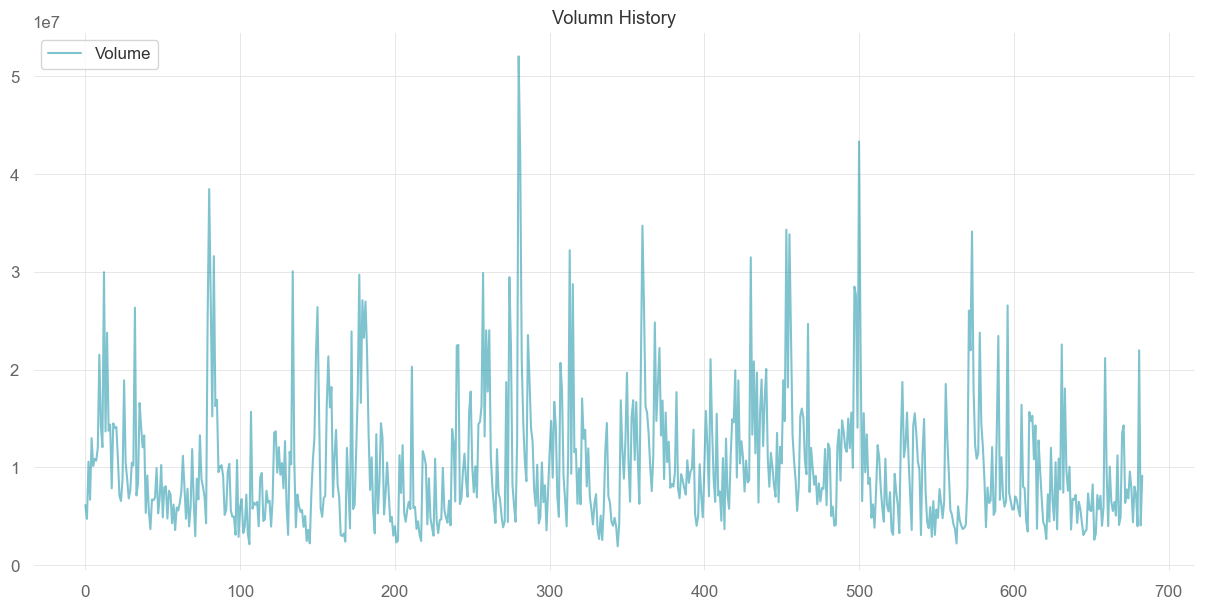

In [269]:
plt.figure(figsize = (15,7))
plt.plot(df['Volume'], color = '#01889f', alpha = 0.5, label = 'Volume')
plt.legend(loc='upper left')
plt.title('Volumn History')

In [270]:
#參數設定
fund = 1000000
stockfee_precent =  0.001425 # 證卷手續費
exchangefee_precent = 0.003  # 交易所手續費
length = 20
NumStd = 1.5
K = 0.15
NumStock = 1000 # 每次交易一張（1000股）

#指標計算
df['MA'] = df['Close'].rolling(window=length, center=False).mean()
df['STD'] = df['Close'].rolling(window=length, center=False).std()
df['upLine'] = df['MA'] + NumStd*df['STD']
df['downLine'] = df['MA'] - NumStd*df['STD']
train_data = df
train_data[20:23]

,Date,Open,High,Low,Close,Adj Close,Volume,MA,STD,upLine,downLine
20,2021/02/01,128.199997,130.949997,127.550003,130.750000,122.770958,14132983,133.035000,4.385656,139.613484,126.456517
21,2021/02/02,132.500000,135.050003,132.500000,134.449997,126.245171,10888373,133.527500,3.916546,139.402320,127.652680
22,2021/02/03,135.449997,135.500000,134.199997,134.350006,126.151268,7081970,133.947501,3.488155,139.179734,128.715267


In [271]:
df_arr = np.array(train_data)
time_arr = np.array(train_data['Date'])
date_arr = [pd.to_datetime(i).date() for i in time_arr]

Enter Long Position
Buy Price: 140.5500030517578, time: 2021/02/18
Sell Price: 139.5500030517578, time: 2021/02/19
Trade completed

Enter Long Position
Buy Price: 137.35000610351562, time: 2021/04/08
Sell Price: 137.1999969482422, time: 2021/04/13
Trade completed

Enter Long Position
Buy Price: 138.89999389648438, time: 2021/04/16
Sell Price: 138.85000610351562, time: 2021/04/20
Trade completed

Enter Long Position
Buy Price: 141.1999969482422, time: 2021/04/27
Sell Price: 141.0, time: 2021/04/29
Trade completed

Enter Short Position
Sell Price: 136.3000030517578, time: 2021/05/06
Buycover Price: 138.14999389648438, time: 2021/05/07
Trade completed

Enter Short Position
Sell Price: 132.89999389648438, time: 2021/05/12
Buycover Price: 132.1999969482422, time: 2021/05/19
Trade completed

Enter Long Position
Buy Price: 139.85000610351562, time: 2021/07/06
Sell Price: 139.14999389648438, time: 2021/07/08
Trade completed

Enter Long Position
Buy Price: 140.9499969482422, time: 2021/07/15
Se

<AxesSubplot:xlabel='Date'>

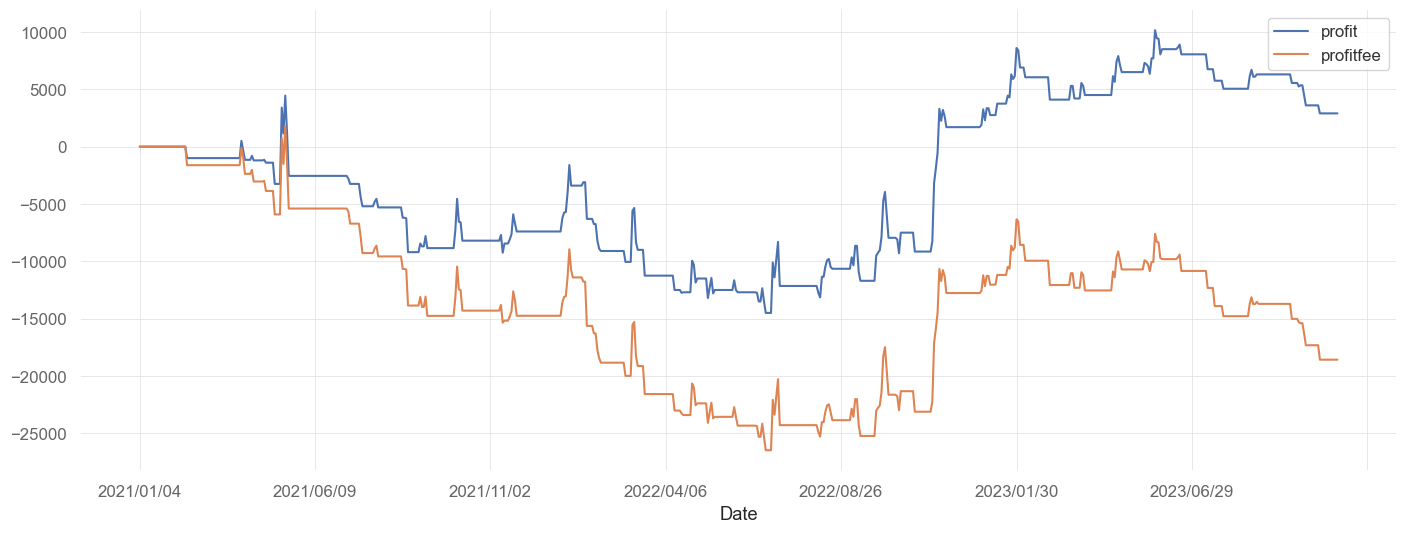

In [272]:
BS = None
buy = []
sell = []
sellshort = []
buytocover = []
profit_list = [0]
profit_fee_list = [0]
profit_fee_list_realized = []
rets = []

for i in range(len(df_arr)):

    if i == len(df_arr)-1:
        break

    ## 進場邏輯
    # 當收盤價突破布林上軌，做多入場
    entryLong = df_arr[i,4] > df_arr[i,9]
    # 當收盤價跌破布林下軌，做空入場
    entrySellShort = df_arr[i,4] < df_arr[i,10]

    ## 出場邏輯
    # 當收盤價跌破布林上軌，做多出場
    exitShort = df_arr[i,4] <= df_arr[i,9]
    # 當收盤價突破布林下軌，做空出場
    exitBuyToCover = df_arr[i,4] >= df_arr[i,10]
    
    ## 停利停損邏輯
    # 做多
    if BS == 'B':
        stopLoss = df_arr[i,4] <= df_arr[t,1] * (1-K)
        stopProfit = df_arr[i,4] >= df_arr[t,1] * (1+K)
    # 做空
    elif BS == 'S':
        stopLoss = df_arr[i,4] >= df_arr[t,1] * (1+K)
        stopProfit = df_arr[i,4] <= df_arr[t,1] * (1-K)

    ##還沒進場不用計算損益
    if BS == None:
        profit_list.append(0)
        profit_fee_list.append(0)

        if entryLong :
            BS = 'B'
            t = i+1
            buy.append(t)
            print("Enter Long Position")
            print("Buy Price: {}, time: {}".format(df_arr[t,1], time_arr[t]))

        elif entrySellShort:
            BS = 'S'
            t = i+1
            sellshort.append(t)
            print("Enter Short Position")
            print("Sell Price: {}, time: {}".format(df_arr[t,1], time_arr[t]))
    
    #進場開始計算未實現損益
    elif BS == 'B':
        profit = (df_arr[i+1,1] - df_arr[i,1])*NumStock
        profit_list.append(profit)
        
        #近場條件達成，計算未實現損益-交易成本
        if exitShort  or stopLoss or stopProfit:
            pl_round = (df_arr[i+1,1] - df_arr[i,1])*NumStock
            profit_fee = profit - df_arr[i+1,1]*NumStock*(stockfee_precent+exchangefee_precent)
            profit_fee_list.append(profit_fee)
            sell.append(i+1)
            BS=None
            print("Sell Price: {}, time: {}".format(df_arr[i+1,1], time_arr[i+1]))
            print("Trade completed")
            print()

            # 以實現盈虧
            profit_fee_realized = pl_round - profit_fee
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(df_arr[t,1]))

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)

    elif BS == 'S':
        profit = (df_arr[i,1] - df_arr[i+1,1])*NumStock
        profit_list.append(profit)

        #出場條件達成，計算未實現損益-交易成本
        if exitBuyToCover   or stopLoss or stopProfit:
            pl_round = (df_arr[t,1] - df_arr[i+1,1])*NumStock
            profit_fee =  profit - df_arr[i+1,1]*NumStock*stockfee_precent
            profit_fee_list.append(profit_fee)
            buytocover.append(i+1)
            BS = None
            print("Buycover Price: {}, time: {}".format(df_arr[i+1,1], time_arr[i+1]))
            print("Trade completed")
            print()

            # Realized PnL
            profit_fee_realized = pl_round - profit_fee
            profit_fee_list_realized.append(profit_fee_realized)
            rets.append(profit_fee_realized/(NumStock*df_arr[t,1]))

        else:
            profit_fee = profit
            profit_fee_list.append(profit_fee)


equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=train_data['Date'])
# print(equity)

equity.plot(grid=True, figsize=(17,6))

In [273]:
equity['equity'] = equity['profitfee'] + fund
equity['drawdown'] = equity['equity'] - equity['equity'].cummax() #前n個元素的最大值
profit = equity['profitfee'].iloc[-1]
ret = equity['equity'][-1]/equity['equity'][0]-1
mdd = abs(equity['drawdown'].min())
calmarRatio = ret / mdd
tradeTimes = len(buy) + len(sellshort)
winRate = len([i for i in profit_fee_list_realized if i > 0]) / len(profit_fee_list_realized)
profitFactor = sum([i for i in profit_fee_list_realized if i>0]) / abs(sum([i for i in profit_fee_list_realized if i<0]))

print('Profit : ',profit)
print('Return : ',ret)
print('Max DrawDown : ',mdd)
print('Caimar Ratio : ',calmarRatio)
print('Trade Times : ',tradeTimes)
print('Win Rate : ',winRate)
print('Profit Factor : ',profitFactor)

Profit :  -18578.2016582489
Return :  -0.01857820165824886
Max DrawDown :  28266.60927181237
Caimar Ratio :  -6.572490347038247e-07
Trade Times :  61
Win Rate :  0.8852459016393442
Profit Factor :  6.435022526063357


### 布林通道參數最佳化

In [282]:
retss = []
length_list = []
numstd_list = []

fund = 1000000
stockfee_precent =  0.001425 # 證卷手續費
exchangefee_precent = 0.003  # 交易所手續費
length = 15
NumStd = 1.5
NumStock = 1000 # 每次交易一張（1000股）


# 最佳化參數：length & NumStd
for length in range(10,110,10):
    for stdTimes in np.arange(0.5, 3, 0.5):

        stdTimes = np.round(stdTimes,1)

        print('----------')
        print(f'length: {length}')
        print(f'stdTimes: {stdTimes}')

        train＿data['MA'] = train_data['Close'].rolling(window=length, center=False).mean()
        train_data['STD'] = train_data['Close'].rolling(window=length, center=False).std()
        train_data['upLine'] = train_data['MA'] + stdTimes*train_data['STD']
        train_data['downLine'] = train_data['MA'] - stdTimes*train_data['STD']


        df_arr = np.array(train_data)
        time_arr = np.array(train_data['Date'])
        date_arr = [pd.to_datetime(i).date() for i in time_arr]

        BS = None
        buy = []
        sell = []
        sellshort = []
        buytocover = []
        profit_list = [0]
        profit_fee_list = [0]
        profit_fee_list_realized = []
        rets = []

        for i in range(len(df_arr)):

            if i == len(df_arr)-1:
                break

            ## 進場邏輯
            # 當收盤價突破布林上軌，做多入場
            entryLong = df_arr[i,4] > df_arr[i,9]
            # 當收盤價跌破布林下軌，做空入場
            entrySellShort = df_arr[i,4] < df_arr[i,10]

            ## 出場邏輯
            # 當收盤價跌破布林上軌，做多出場
            exitShort = df_arr[i,4] <= df_arr[i,9]
            # 當收盤價突破布林下軌，做空出場
            exitBuyToCover = df_arr[i,4] >= df_arr[i,10]
            

            ## 停利停損邏輯
             # 做多
            if BS == 'B':
                stopLoss = df_arr[i,4] <= df_arr[t,1] * (1-K)
                stopProfit = df_arr[i,4] >= df_arr[t,1] * (1+K)
            # 做空
            elif BS == 'S':
                stopLoss = df_arr[i,4] >= df_arr[t,1] * (1+K)
                stopProfit = df_arr[i,4] <= df_arr[t,1] * (1-K)


            ##還沒進場不用計算損益
            if BS == None:
                profit_list.append(0)
                profit_fee_list.append(0)

                if entryLong :
                    BS = 'B'
                    t = i+1
                    buy.append(t)

                elif entrySellShort:
                    BS = 'S'
                    t = i+1
                    sellshort.append(t)

            elif BS == 'B':
                profit = (df_arr[i+1,1] - df_arr[i,1])*NumStock
                profit_list.append(profit)
                
                #近場條件達成，計算未實現損益-交易成本
                if exitShort  or stopLoss or stopProfit:
                    pl_round = (df_arr[i+1,1] - df_arr[i,1])*NumStock
                    profit_fee = profit - df_arr[i+1,1]*NumStock*(stockfee_precent+exchangefee_precent)
                    profit_fee_list.append(profit_fee)
                    sell.append(i+1)
                    BS=None

                    # 以實現盈虧
                    profit_fee_realized = pl_round - profit_fee
                    profit_fee_list_realized.append(profit_fee_realized)
                    rets.append(profit_fee_realized/(df_arr[t,1]))

                else:
                    profit_fee = profit
                    profit_fee_list.append(profit_fee)
            
            elif BS == 'S':
                profit = (df_arr[i,1] - df_arr[i+1,1])*NumStock
                profit_list.append(profit)

                #出場條件達成，計算未實現損益-交易成本
                if exitBuyToCover   or stopLoss or stopProfit:
                    pl_round = (df_arr[t,1] - df_arr[i+1,1])*NumStock
                    profit_fee =  profit - df_arr[i+1,1]*NumStock*stockfee_precent
                    profit_fee_list.append(profit_fee)
                    buytocover.append(i+1)
                    BS = None

                    # Realized PnL
                    profit_fee_realized = pl_round - profit_fee
                    profit_fee_list_realized.append(profit_fee_realized)
                    rets.append(profit_fee_realized/(NumStock*df_arr[t,1]))

                else:
                    profit_fee = profit
                    profit_fee_list.append(profit_fee)
            
            

        equity = pd.DataFrame({'profit':np.cumsum(profit_list), 'profitfee':np.cumsum(profit_fee_list)}, index=train_data['Date'])
        equity['equity'] = equity['profitfee'] + fund
        equity['drawdown'] = equity['equity'] - equity['equity'].cummax()
        ret = (equity['equity'][-1]/equity['equity'][0]) - 1
        retss.append(ret)
        mdd = abs(equity['drawdown'].min())
        calmarRatio = ret / mdd
        print('return precentage: {}'.format(ret))
        print('Calmar Ratio: {}'.format(calmarRatio))
        length_list.append(length)
        numstd_list.append(NumStd)

index = retss.index(max(retss))
print('optimal length: {}'.format(length_list[index]))
print('optimal NumStd: {}'.format(numstd_list[index]))


----------
length: 10
stdTimes: 0.5
return precentage: -0.05226081015777584
Calmar Ratio: -8.545814322165638e-07
----------
length: 10
stdTimes: 1.0
return precentage: -0.030683308505058293
Calmar Ratio: -8.156323156682179e-07
----------
length: 10
stdTimes: 1.5
return precentage: -0.02947544711246497
Calmar Ratio: -8.686267691620513e-07
----------
length: 10
stdTimes: 2.0
return precentage: -0.025399786107826228
Calmar Ratio: -8.986046489259218e-07
----------
length: 10
stdTimes: 2.5
return precentage: -0.00039144820499414923
Calmar Ratio: -6.80452247544917e-07
----------
length: 20
stdTimes: 0.5
return precentage: -0.04961507910289764
Calmar Ratio: -8.832867689251053e-07
----------
length: 20
stdTimes: 1.0
return precentage: -0.042384014122581415
Calmar Ratio: -9.591857794239318e-07
----------
length: 20
stdTimes: 1.5
return precentage: -0.01857820165824886
Calmar Ratio: -6.572490347038247e-07
----------
length: 20
stdTimes: 2.0
return precentage: -0.006404800151061929
Calmar Ratio: 